# General Functions to use

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import keras.models as models
import keras.layers as layers
from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU, ELU

np.random.seed(101)

Using TensorFlow backend.


In [2]:
def create_timestepped_data(data_frame, time_steps):
    d = []
    for i in range(time_steps):
        d.append(data_frame.shift(-i).values[:-time_steps])
    return np.transpose(np.array(d),(1,0,2))

In [3]:
def create_formatted_data(time_steps, num_features, df, columns):
    data = df[columns]
    data_norm = (data - data.min())/(2**np.ceil(np.log2(data.max())) - data.min())

    d = create_timestepped_data(pd.DataFrame(data_norm),time_steps)
    past = d[:,:int(time_steps/2),:]
    fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
    cur = d[:,int(time_steps/2),:-1]
    cur = np.dstack((cur.reshape(-1,1,4),np.zeros(shape=(cur.shape[0],1,252))))
    y = d[:,int(time_steps/2),-1] * (2**np.ceil(np.log2(data.max()))[-1] - data.min()[-1]) + data.min()[-1]
    
    return past,fut,cur,y

In [4]:
def train_test_split(past,fut,cur,y):
    train_split = int(0.7*y.shape[0])
    return past[:train_split], past[train_split:], fut[:train_split], np.zeros_like(past[train_split:]), cur[:train_split], cur[train_split:], y[:train_split], y[train_split:]    

In [5]:
def model_build(input_shape1, input_shape2, cur_input_shape):
    
    past_inp = layers.Input(shape=(input_shape1))
    fut_inp = layers.Input(shape=(input_shape2))
    cur_inp = layers.Input(shape=(cur_input_shape))
    
    cnn1 = layers.Conv1D(filters=256,kernel_size=5)(past_inp)
    #cnn1 = layers.MaxPool1D(pool_size=2)(cnn1)
    cnn1 = layers.Conv1D(filters=256,kernel_size=2)(cnn1)
    cnn1 = layers.Dense(256)(cnn1)
    cnn1 = layers.advanced_activations.LeakyReLU(0.2)(cnn1)
    
    cnn2 = layers.Conv1D(filters=256,kernel_size=5)(fut_inp)
    #cnn2 = layers.MaxPool1D(pool_size=2)(cnn2)
    cnn2 = layers.Conv1D(filters=256,kernel_size=2)(cnn2)
    cnn2 = layers.Dense(256)(cnn2)
    cnn2 = layers.advanced_activations.LeakyReLU(0.2)(cnn2)
    
    cnn_out = layers.Concatenate(axis=1)([cnn1,cnn2])
    lstm_inp = layers.Add()([cnn_out,cur_inp])
    
    x1 = layers.LSTM(832, unroll=True, return_sequences=True)(lstm_inp)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.LSTM(832, unroll=True, return_sequences=True)(x1)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.LSTM(832, unroll=True, return_sequences=True)(x1)
    x1 = layers.Dense(256)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    lstm_out = layers.Dropout(0.2)(x1)
    
    x1 = layers.Concatenate(axis=1)([lstm_out,cnn_out])
    x1 = layers.Flatten()(x1)
    
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1)(x1)
    main_out = layers.advanced_activations.LeakyReLU(0.2)(x1)
    
    model = models.Model(inputs=[past_inp,fut_inp,cur_inp], outputs=[main_out], name='CLDNN')
    model.summary()
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model
    
    

# SPI Data

In [7]:
time_steps = 21
num_features = 5
df = pd.read_csv("notNiteeshData.csv")
food='ES_POPCORN SMALL'
columns = ['tamil','english','hindi','others',food]
past,fut,cur,y = create_formatted_data(time_steps, num_features, df, columns)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)
model = model_build(past.shape[1:],fut.shape[1:],cur.shape[1:])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 5)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 5)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 256)       6656        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 256)       6656        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

In [8]:
past_test = past_test * 2

In [9]:
model.fit(x=[past_train,fut_train,cur_train], y=y_train, epochs=100, batch_size=32,
          validation_data=([past_test,fut_test,cur_test],y_test))

Train on 679 samples, validate on 291 samples
Epoch 1/100
679/679 [==============================] - 16s 23ms/step - loss: 185101.7880 - mean_absolute_error: 375.4475 - val_loss: 87086.2952 - val_mean_absolute_error: 274.0967
Epoch 2/100
679/679 [==============================] - 11s 16ms/step - loss: 56951.5956 - mean_absolute_error: 184.4452 - val_loss: 12656.3316 - val_mean_absolute_error: 86.4485
Epoch 3/100
679/679 [==============================] - 11s 16ms/step - loss: 21705.1472 - mean_absolute_error: 114.5454 - val_loss: 26720.5544 - val_mean_absolute_error: 136.8356
Epoch 4/100
679/679 [==============================] - 11s 16ms/step - loss: 16563.8064 - mean_absolute_error: 95.7694 - val_loss: 37379.3060 - val_mean_absolute_error: 170.4280
Epoch 5/100
679/679 [==============================] - 11s 16ms/step - loss: 11274.5848 - mean_absolute_error: 79.2979 - val_loss: 34164.2241 - val_mean_absolute_error: 167.6962
Epoch 6/100
679/679 [==============================] - 11s 16

Epoch 47/100
679/679 [==============================] - 11s 16ms/step - loss: 2538.9963 - mean_absolute_error: 38.8753 - val_loss: 19384.1070 - val_mean_absolute_error: 105.8054
Epoch 48/100
679/679 [==============================] - 11s 16ms/step - loss: 1783.9011 - mean_absolute_error: 33.1377 - val_loss: 11179.9653 - val_mean_absolute_error: 79.8059
Epoch 49/100
679/679 [==============================] - 11s 16ms/step - loss: 1874.8169 - mean_absolute_error: 33.4631 - val_loss: 8548.5292 - val_mean_absolute_error: 67.1630
Epoch 50/100
679/679 [==============================] - 11s 16ms/step - loss: 1638.0297 - mean_absolute_error: 31.6187 - val_loss: 10668.9779 - val_mean_absolute_error: 74.7641
Epoch 51/100
679/679 [==============================] - 11s 16ms/step - loss: 1917.1051 - mean_absolute_error: 32.8708 - val_loss: 17967.0765 - val_mean_absolute_error: 103.1289
Epoch 52/100
679/679 [==============================] - 10s 15ms/step - loss: 2212.2295 - mean_absolute_error: 35.

679/679 [==============================] - 10s 15ms/step - loss: 574.2600 - mean_absolute_error: 18.7691 - val_loss: 13539.2939 - val_mean_absolute_error: 89.7401
Epoch 94/100
679/679 [==============================] - 11s 16ms/step - loss: 675.5654 - mean_absolute_error: 19.9474 - val_loss: 15897.2916 - val_mean_absolute_error: 97.9960
Epoch 95/100
679/679 [==============================] - 11s 16ms/step - loss: 1779.6695 - mean_absolute_error: 33.2078 - val_loss: 14957.4449 - val_mean_absolute_error: 92.3079
Epoch 96/100
679/679 [==============================] - 11s 16ms/step - loss: 4560.6336 - mean_absolute_error: 52.7065 - val_loss: 18636.3643 - val_mean_absolute_error: 107.6683
Epoch 97/100
679/679 [==============================] - 11s 16ms/step - loss: 2550.2470 - mean_absolute_error: 39.3361 - val_loss: 15934.0951 - val_mean_absolute_error: 91.2058
Epoch 98/100
679/679 [==============================] - 11s 16ms/step - loss: 2562.7685 - mean_absolute_error: 39.0977 - val_loss

In [10]:
y_pred = model.predict([past_test, fut_test, cur_test], batch_size=32)
#y_pred = model.predict([past, fut, cur], batch_size=32)
pred = pd.Series(np.array(y_pred).reshape((-1,)))
test = pd.Series(y_test.reshape((-1,)))
print(pred.shape, test.shape)

(291,) (291,)


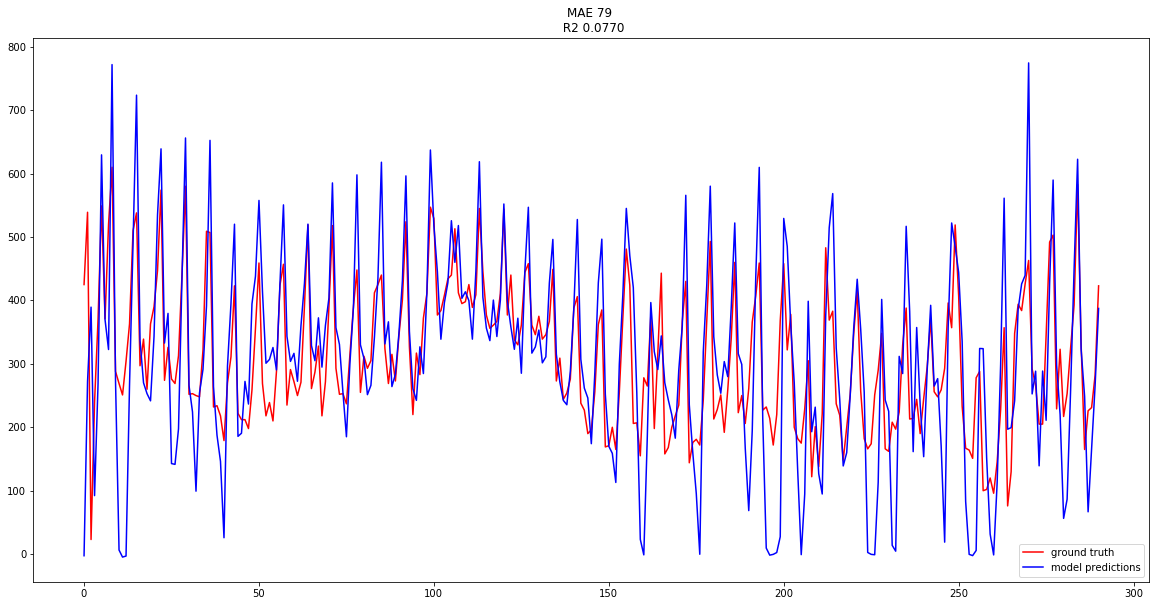

In [11]:
# Just for fun did for entire data
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

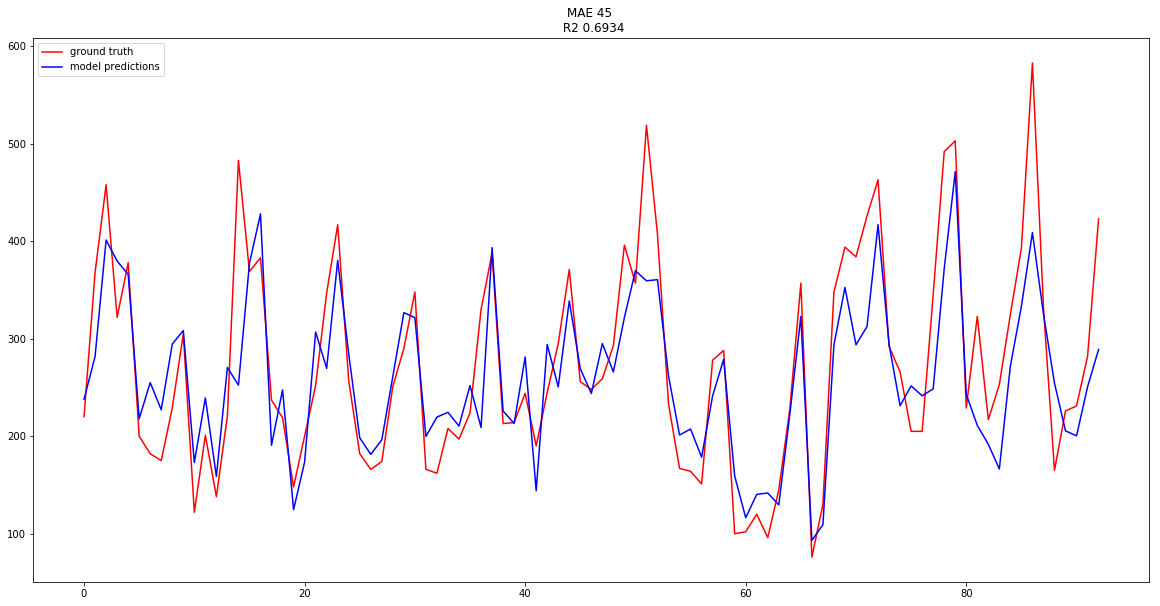

In [10]:
# Just for fun did for entire data
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

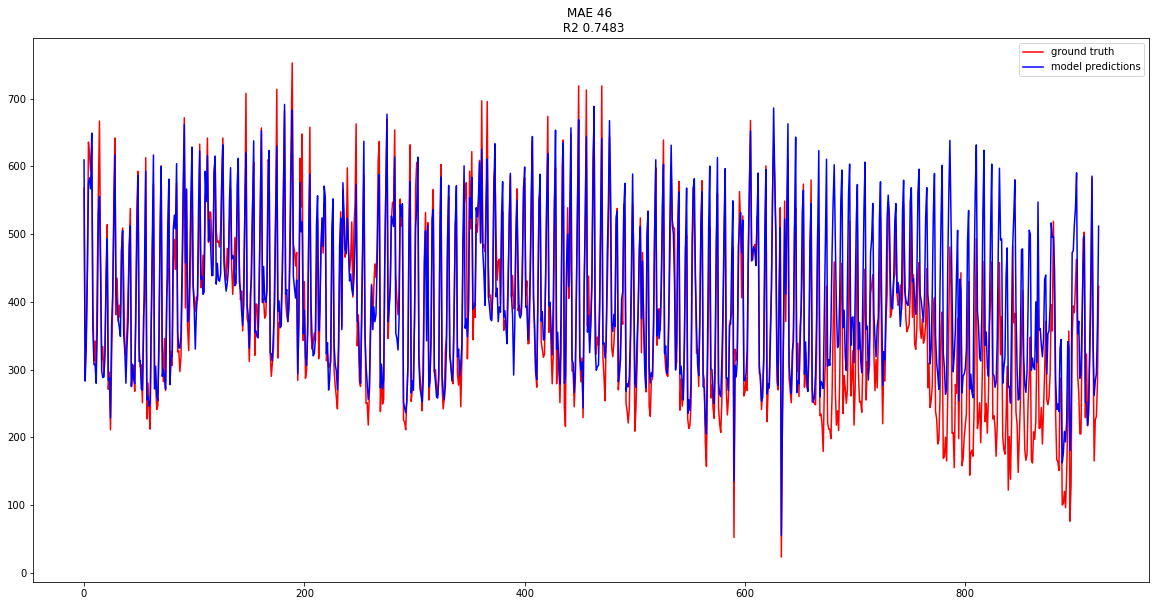

In [14]:
# Just for fun did for entire data
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(y,pred), r2_score(y,pred)))
plt.plot(y, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

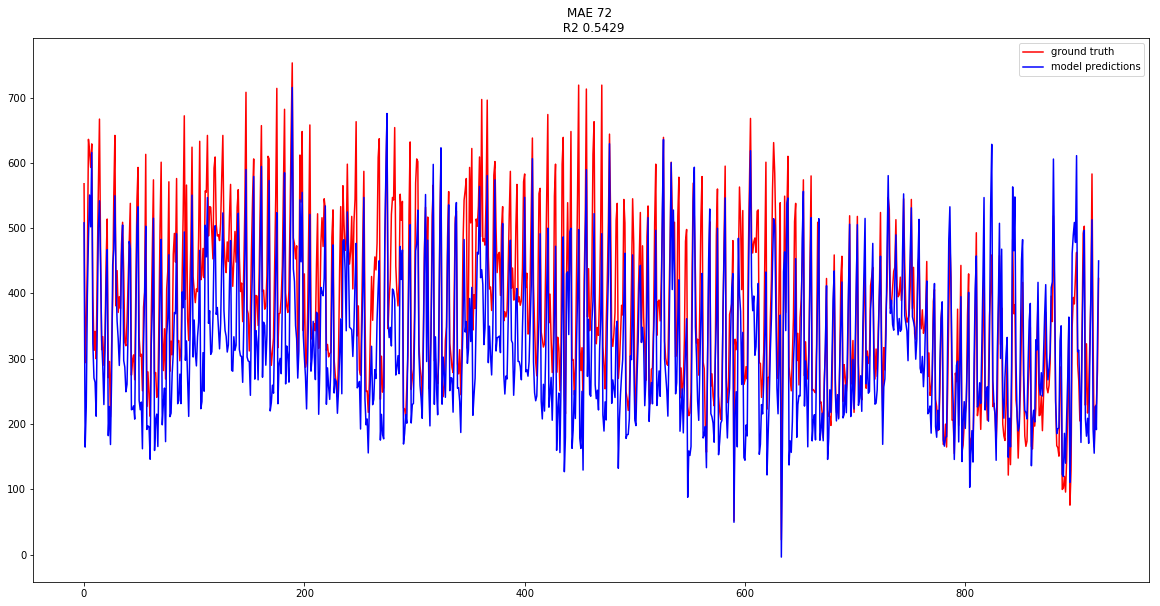

In [25]:
# Just for fun did for entire data
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

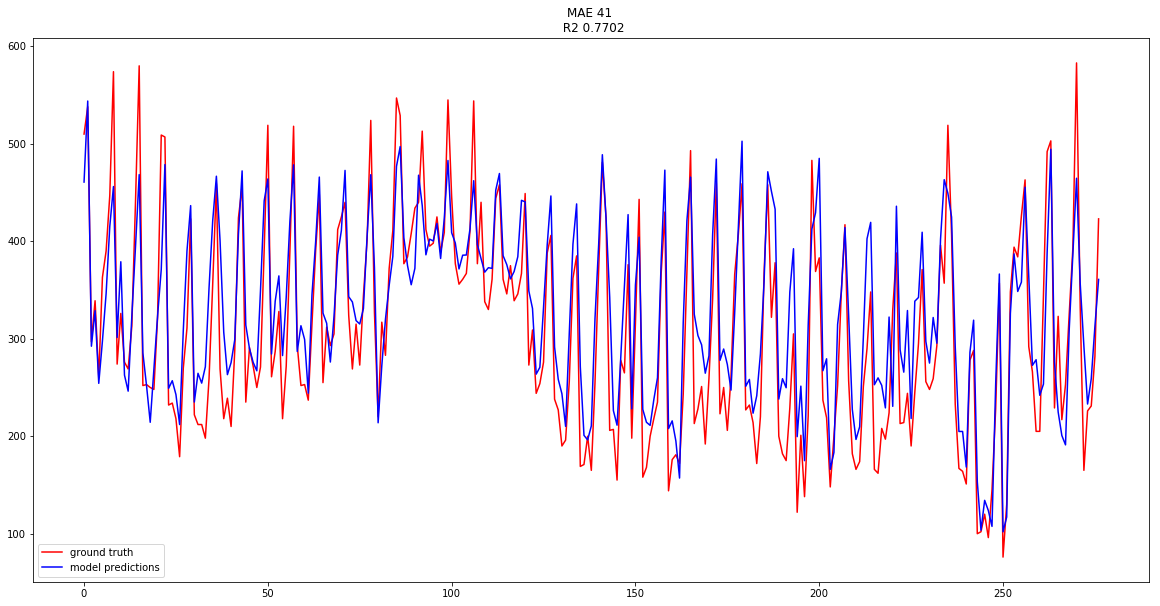

In [13]:
# Add CNN's outputs min() and max() as next lower and next highest 2 power
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

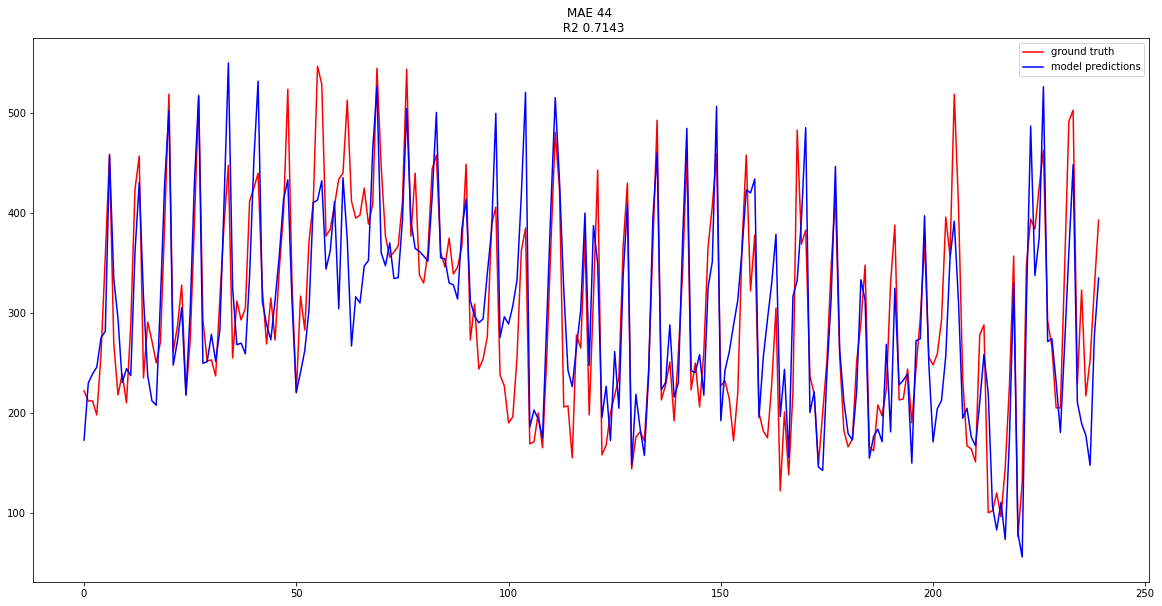

In [19]:
# Add CNN's outputs max() as next highest 2 power
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

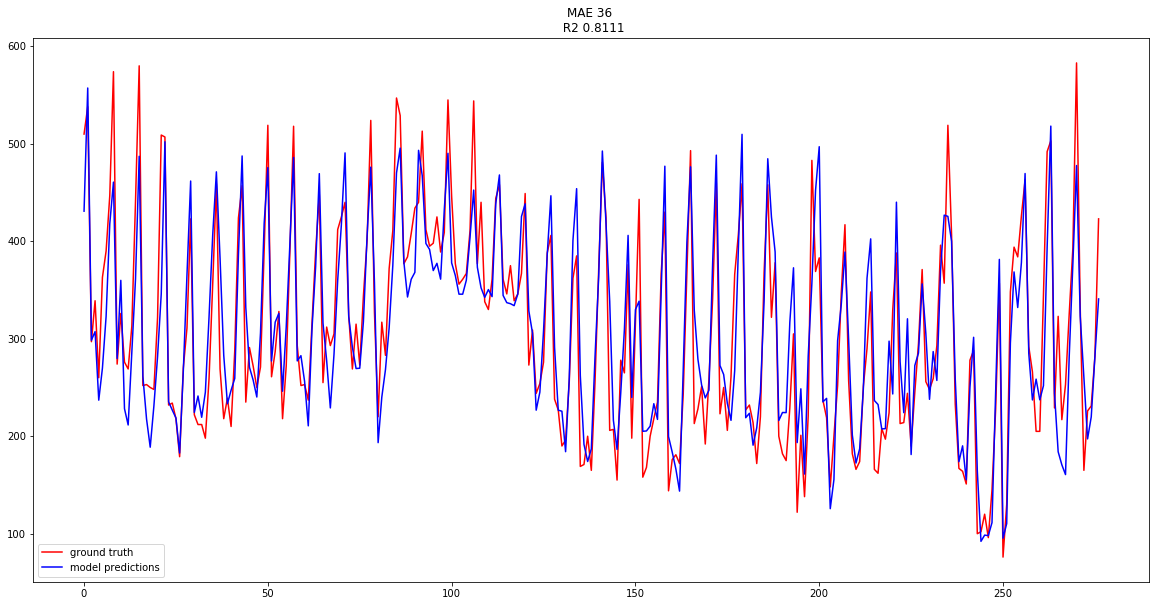

In [29]:
# Add CNN's outputs
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

# Airpassengers Data 

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
(123, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Con

Train on 100 samples, validate on 23 samples
Epoch 1/200
100/100 [==============================] - 7s 69ms/step - loss: 53820298690.5600 - mean_absolute_error: 219409.5113 - val_loss: 10775784448.0000 - val_mean_absolute_error: 77761.0391
Epoch 2/200
100/100 [==============================] - 2s 18ms/step - loss: 126244736696.3200 - mean_absolute_error: 240701.1800 - val_loss: 92899893248.0000 - val_mean_absolute_error: 298032.9688
Epoch 3/200
100/100 [==============================] - 2s 18ms/step - loss: 44353002045.4400 - mean_absolute_error: 197563.5000 - val_loss: 142269464576.0000 - val_mean_absolute_error: 372231.1875
Epoch 4/200
100/100 [==============================] - 2s 18ms/step - loss: 54349634600.9600 - mean_absolute_error: 220622.1769 - val_loss: 144917446656.0000 - val_mean_absolute_error: 375790.6875
Epoch 5/200
100/100 [==============================] - 2s 18ms/step - loss: 54809656360.9600 - mean_absolute_error: 221561.4231 - val_loss: 142959755264.0000 - val_mean_

Epoch 86/200
100/100 [==============================] - 2s 18ms/step - loss: 177260960.0000 - mean_absolute_error: 10490.1259 - val_loss: 414552672.0000 - val_mean_absolute_error: 16392.6055
Epoch 87/200
100/100 [==============================] - 2s 18ms/step - loss: 119891582.3200 - mean_absolute_error: 8721.8727 - val_loss: 433594336.0000 - val_mean_absolute_error: 16571.3242
Epoch 88/200
100/100 [==============================] - 2s 18ms/step - loss: 114122231.0400 - mean_absolute_error: 8730.4022 - val_loss: 754108864.0000 - val_mean_absolute_error: 22702.0156
Epoch 89/200
100/100 [==============================] - 2s 18ms/step - loss: 176097770.2400 - mean_absolute_error: 9931.9967 - val_loss: 412050848.0000 - val_mean_absolute_error: 16258.8984
Epoch 90/200
100/100 [==============================] - 2s 18ms/step - loss: 129921898.2400 - mean_absolute_error: 8811.9345 - val_loss: 617038784.0000 - val_mean_absolute_error: 21299.6504
Epoch 91/200
100/100 [===========================

100/100 [==============================] - 2s 18ms/step - loss: 44518818.7200 - mean_absolute_error: 5377.4618 - val_loss: 407714720.0000 - val_mean_absolute_error: 15898.9502
Epoch 173/200
100/100 [==============================] - 2s 18ms/step - loss: 97105245.4400 - mean_absolute_error: 8246.6129 - val_loss: 215604944.0000 - val_mean_absolute_error: 12098.9521
Epoch 174/200
100/100 [==============================] - 2s 18ms/step - loss: 72867928.3200 - mean_absolute_error: 6646.0860 - val_loss: 644091648.0000 - val_mean_absolute_error: 20528.5957
Epoch 175/200
100/100 [==============================] - 2s 18ms/step - loss: 101007850.8800 - mean_absolute_error: 8197.1950 - val_loss: 402916896.0000 - val_mean_absolute_error: 16595.7930
Epoch 176/200
100/100 [==============================] - 2s 18ms/step - loss: 86693271.3600 - mean_absolute_error: 7495.2670 - val_loss: 204669344.0000 - val_mean_absolute_error: 10543.1465
Epoch 177/200
100/100 [==============================] - 2s 18m

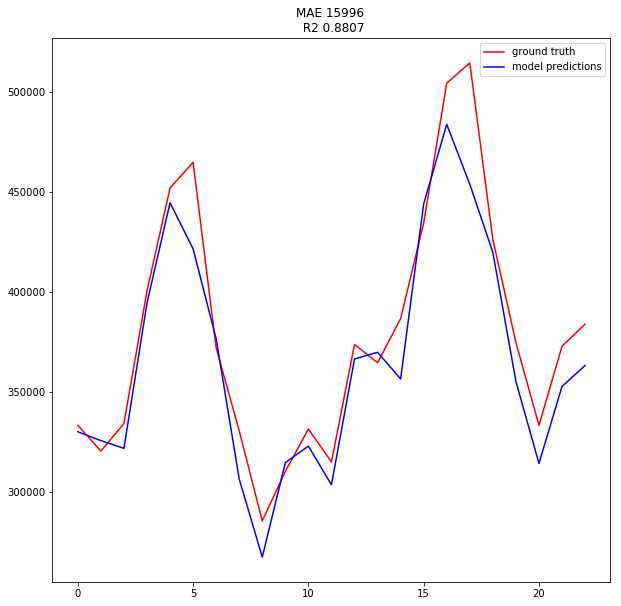

In [11]:
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

data.index

ts = data['#Passengers'] 
ts.head(10)

#1. Specific the index as a string constant:
ts['1949-01-01']

#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(1949,1,1)]

#1. Specify the entire range:
ts['1949-01-01':'1949-05-01']

#2. Use ':' if one of the indices is at ends:
ts[:'1949-05-01']

ts['1949']
# plt.plot(ts)

data = pd.DataFrame(ts)
data_norm = pd.DataFrame(ts)
#data_norm = (data - data.min())/(2**np.ceil(np.log2(data.max())) - data.min())
d = create_timestepped_data(pd.DataFrame(data_norm),time_steps)
past = d[:,:int(time_steps/2),:]
fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
cur = d[:,int(time_steps/2),:]
print(cur.shape)
cur = np.dstack((cur.reshape(-1,1,1),np.zeros(shape=(cur.shape[0],1,255))))
y = d[:,int(time_steps/2),] * (2**np.ceil(np.log2(data.max()))[-1] - data.min()[-1]) + data.min()[-1]
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])

model1.fit([past[:100], fut[:100], cur[:100]], y[:100], epochs=200, batch_size=32, validation_data=([past[100:],fut[100:],cur[100:]],y[100:]))

pred = model1.predict([past[100:],fut[100:],cur[100:]])
pred = np.array(pred).reshape((-1,))
test = y[100:].reshape((-1,))

print(pred.shape, test.shape)

from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()


(123,) (123,)


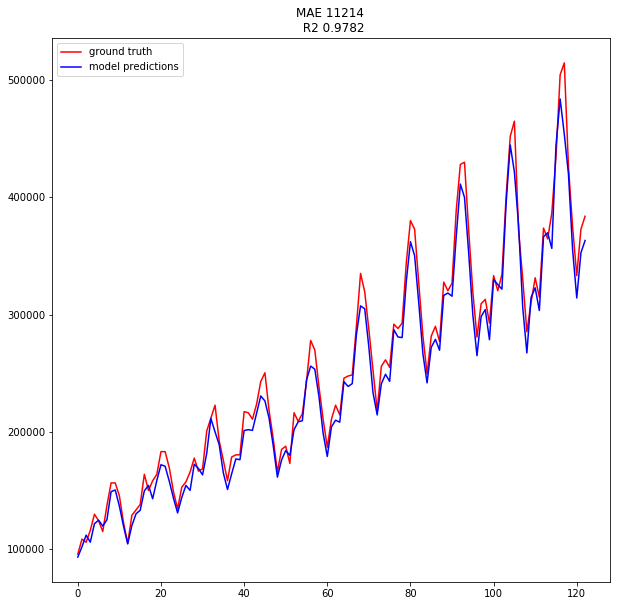

In [14]:
pred = model1.predict([past,fut,cur])
pred = np.array(pred).reshape((-1,))
test = y.reshape((-1,))

print(pred.shape, test.shape)

from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()


In [12]:

pred = pred[test!=0]
test = test[test!=0]
print ('Mape: ',np.mean(np.abs(test-pred)/test))

Mape:  0.0407490666459


# Monthly sunspot

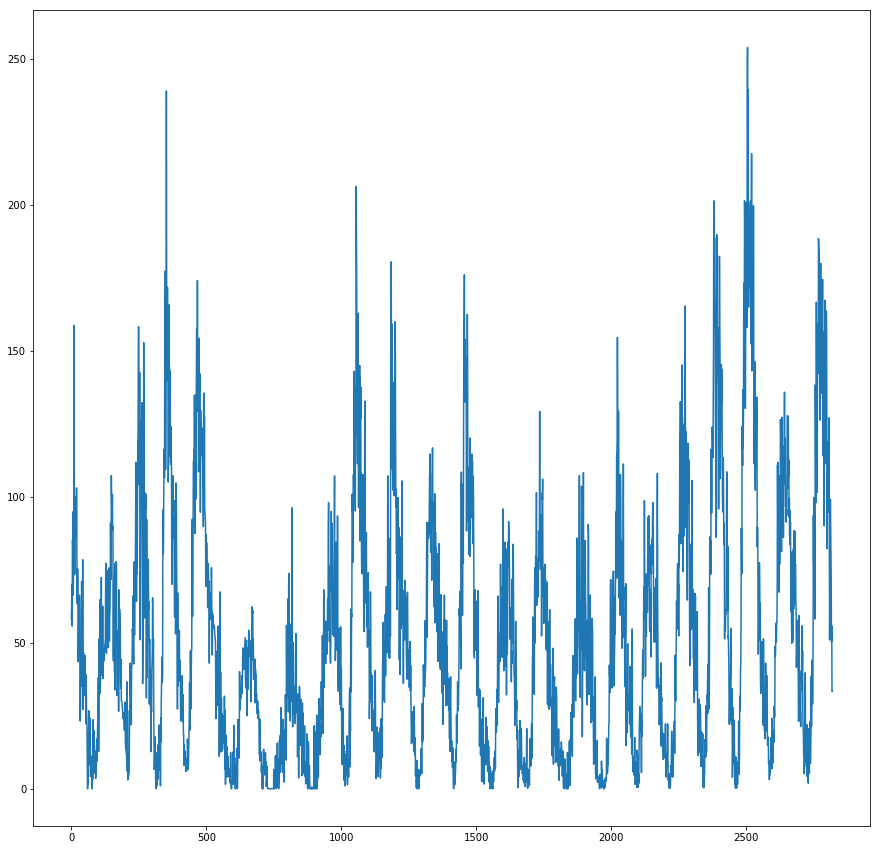

(2800, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 256)       1536        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 256)       1536        input_2[0][0]                    
__________________________________________________________________________________________________


Train on 100 samples, validate on 2700 samples
Epoch 1/200
100/100 [==============================] - 15s 145ms/step - loss: 122859260.3200 - mean_absolute_error: 8574.3976 - val_loss: 3681558205.2504 - val_mean_absolute_error: 50710.4422
Epoch 2/200
100/100 [==============================] - 9s 86ms/step - loss: 534734592.6400 - mean_absolute_error: 15235.0525 - val_loss: 271138188.4807 - val_mean_absolute_error: 12491.1129
Epoch 3/200
100/100 [==============================] - 9s 87ms/step - loss: 134023734.2400 - mean_absolute_error: 8986.7436 - val_loss: 297390281.3519 - val_mean_absolute_error: 13136.8729
Epoch 4/200
100/100 [==============================] - 9s 87ms/step - loss: 139635365.4400 - mean_absolute_error: 9203.5172 - val_loss: 295633434.6400 - val_mean_absolute_error: 13091.9768
Epoch 5/200
100/100 [==============================] - 9s 87ms/step - loss: 137255207.6800 - mean_absolute_error: 9106.4462 - val_loss: 269629649.3519 - val_mean_absolute_error: 12424.7489
Epoc

Epoch 45/200
100/100 [==============================] - 9s 87ms/step - loss: 1210903.1150 - mean_absolute_error: 779.3398 - val_loss: 3727307.0907 - val_mean_absolute_error: 1249.9098
Epoch 46/200
100/100 [==============================] - 9s 87ms/step - loss: 803906.8450 - mean_absolute_error: 694.1640 - val_loss: 2405290.4788 - val_mean_absolute_error: 883.7530
Epoch 47/200
100/100 [==============================] - 9s 87ms/step - loss: 1170093.8850 - mean_absolute_error: 700.0835 - val_loss: 6308089.4609 - val_mean_absolute_error: 1635.3353
Epoch 48/200
100/100 [==============================] - 9s 87ms/step - loss: 533970.3900 - mean_absolute_error: 554.7223 - val_loss: 3660327.1396 - val_mean_absolute_error: 1252.4113
Epoch 49/200
100/100 [==============================] - 9s 87ms/step - loss: 570468.4750 - mean_absolute_error: 620.5054 - val_loss: 4683627.9644 - val_mean_absolute_error: 1145.4105
Epoch 50/200
100/100 [==============================] - 9s 87ms/step - loss: 614858.

Epoch 90/200
100/100 [==============================] - 9s 87ms/step - loss: 1014273.8450 - mean_absolute_error: 724.0058 - val_loss: 7996400.3531 - val_mean_absolute_error: 1569.2356
Epoch 91/200
100/100 [==============================] - 9s 87ms/step - loss: 784102.0100 - mean_absolute_error: 649.0019 - val_loss: 8274712.6566 - val_mean_absolute_error: 1550.7697
Epoch 92/200
100/100 [==============================] - 9s 87ms/step - loss: 624291.5406 - mean_absolute_error: 544.7707 - val_loss: 3152207.4111 - val_mean_absolute_error: 1112.5380
Epoch 93/200
100/100 [==============================] - 9s 87ms/step - loss: 888706.6625 - mean_absolute_error: 666.0959 - val_loss: 7087093.4383 - val_mean_absolute_error: 1632.3922
Epoch 94/200
100/100 [==============================] - 9s 87ms/step - loss: 1321633.2600 - mean_absolute_error: 929.2503 - val_loss: 16875158.1331 - val_mean_absolute_error: 2797.6081
Epoch 95/200
100/100 [==============================] - 9s 87ms/step - loss: 24725

Epoch 135/200
100/100 [==============================] - 9s 92ms/step - loss: 54718.5016 - mean_absolute_error: 186.2810 - val_loss: 3176352.6410 - val_mean_absolute_error: 891.6335
Epoch 136/200
100/100 [==============================] - 9s 89ms/step - loss: 75605.0594 - mean_absolute_error: 194.3460 - val_loss: 2205822.2497 - val_mean_absolute_error: 852.6640
Epoch 137/200
100/100 [==============================] - 9s 92ms/step - loss: 103376.5450 - mean_absolute_error: 245.0087 - val_loss: 2369456.8526 - val_mean_absolute_error: 804.8354
Epoch 138/200
100/100 [==============================] - 9s 87ms/step - loss: 218706.2500 - mean_absolute_error: 297.7922 - val_loss: 3753421.8050 - val_mean_absolute_error: 972.1720
Epoch 139/200
100/100 [==============================] - 9s 93ms/step - loss: 94258.2850 - mean_absolute_error: 230.5852 - val_loss: 3713373.5184 - val_mean_absolute_error: 994.5713
Epoch 140/200
100/100 [==============================] - 9s 92ms/step - loss: 170043.216

Epoch 180/200
100/100 [==============================] - 9s 89ms/step - loss: 84328417.2800 - mean_absolute_error: 6865.7302 - val_loss: 31600637.7541 - val_mean_absolute_error: 4521.8646
Epoch 181/200
100/100 [==============================] - 9s 89ms/step - loss: 24383505.2000 - mean_absolute_error: 3563.3637 - val_loss: 26237304.7307 - val_mean_absolute_error: 3489.6253
Epoch 182/200
100/100 [==============================] - 9s 93ms/step - loss: 16952094.6800 - mean_absolute_error: 2927.0295 - val_loss: 37560802.0141 - val_mean_absolute_error: 4115.4076
Epoch 183/200
100/100 [==============================] - 9s 94ms/step - loss: 18467178.9600 - mean_absolute_error: 2851.9874 - val_loss: 59482735.3911 - val_mean_absolute_error: 5387.4658
Epoch 184/200
100/100 [==============================] - 9s 94ms/step - loss: 29543470.9600 - mean_absolute_error: 3804.3586 - val_loss: 22319755.1311 - val_mean_absolute_error: 3460.7871
Epoch 185/200
100/100 [==============================] - 9s 

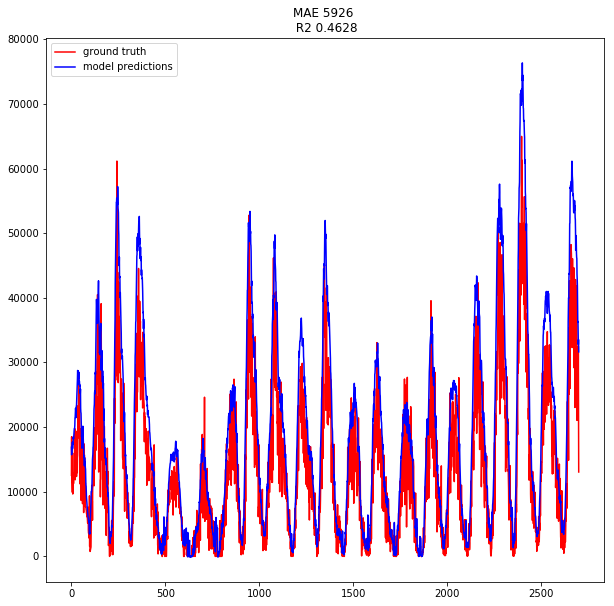

In [7]:
ts = pd.read_csv("zuerich-monthly-sunspot-numbers-.csv")['Zuerich monthly sunspot numbers 1749-1983']
plt.figure(figsize=(15,15))
plt.plot(ts)
plt.show()

time_steps = 21
num_features = 1

data = pd.DataFrame(ts)
data_norm = pd.DataFrame(ts)
#data_norm = (data - data.min())/(2**np.ceil(np.log2(data.max())) - data.min())
d = create_timestepped_data(pd.DataFrame(data_norm),time_steps)
past = d[:,:int(time_steps/2),:]
fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
cur = d[:,int(time_steps/2),:]
print(cur.shape)
cur = np.dstack((cur.reshape(-1,1,1),np.zeros(shape=(cur.shape[0],1,255))))
y = d[:,int(time_steps/2),] * (2**np.ceil(np.log2(data.max()))[-1] - data.min()[-1]) + data.min()[-1]
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])

model1.fit([past[:100], fut[:100], cur[:100]], y[:100], epochs=200, batch_size=32, validation_data=([past[100:],fut[100:],cur[100:]],y[100:]))

pred = model1.predict([past[100:],fut[100:],cur[100:]])
pred = np.array(pred).reshape((-1,))
test = y[100:].reshape((-1,))

print(pred.shape, test.shape)

from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

# Not using